<h1>
<hr style=" border:none; height:3px;">
<center>Custom Logo - Dreamshaper finetuned</center>
<hr style=" border:none; height:3px;">
</h1>

<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h4><center>Louis LHOTTE | Clément VERON | Edouard SEGUIER</center></h4>

In [1]:
from datasets import load_dataset
from diffusers import UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model
import torch
import matplotlib.pyplot as plt
import pickle
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import mse_loss
import torch.nn.functional as F

# I - Dataset

In [2]:
ds = load_dataset("logo-wizard/modern-logo-dataset")
train_dataset = ds['train']

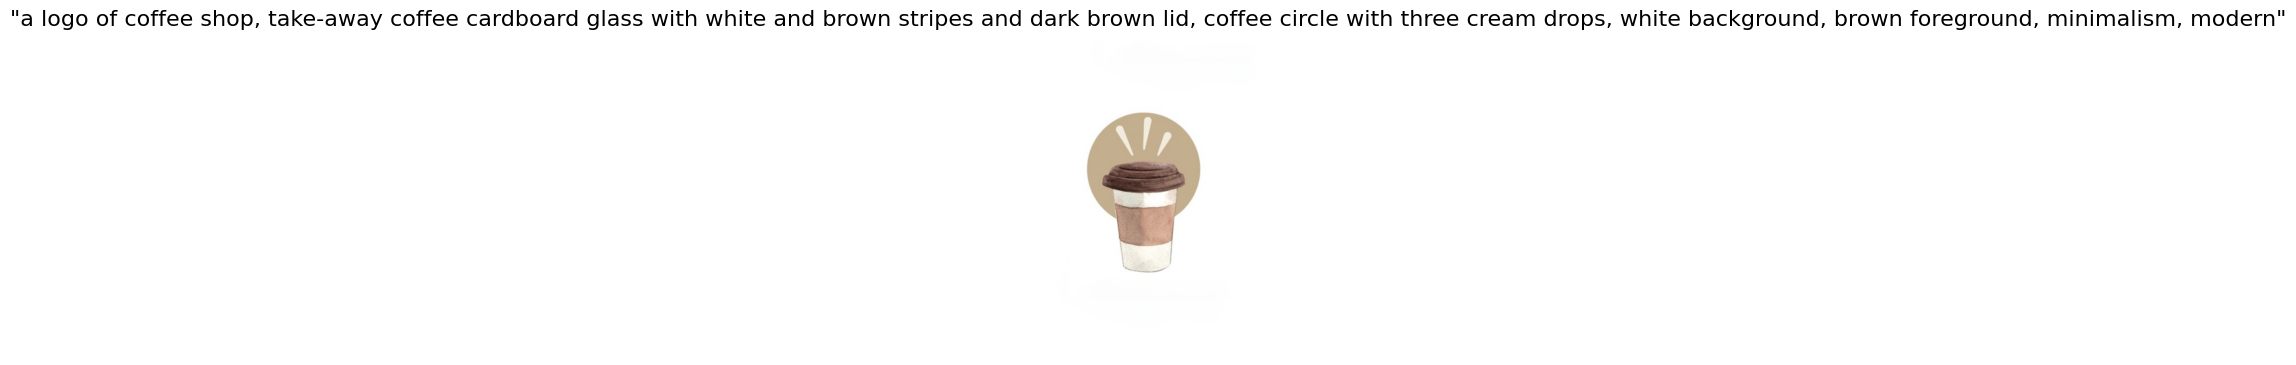

In [3]:
first_item = ds['train'][0]
image = first_item['image']
text = first_item['text']

plt.figure(figsize=(4, 6))
plt.imshow(image)
plt.axis("off")
plt.title(text, fontsize=16)
plt.show()

# II - Base model

In [4]:
model_id = "runwayml/stable-diffusion-v1-5"
device: str = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
print("Tokenizer loaded")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
print("Text encoder loaded")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae").to(device)
print("VAE loaded")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
print("Unet loaded")

Tokenizer loaded
Text encoder loaded
VAE loaded
Unet loaded


# III - Config, peft model

In [5]:
target_modules = [
    "mid_block.attentions.0.proj_in",
    "mid_block.attentions.0.proj_out",
    "mid_block.attentions.0.transformer_blocks.0.attn1.to_q",
    "mid_block.attentions.0.transformer_blocks.0.attn1.to_k",
    "mid_block.attentions.0.transformer_blocks.0.attn1.to_v",
]

config = LoraConfig(
    r=1,
    lora_alpha=32,
    target_modules=target_modules,
    lora_dropout=0.1,
    bias="none"
)

lora_unet = get_peft_model(unet, config)
lora_unet = lora_unet.to("cuda")
optimizer = torch.optim.AdamW(lora_unet.parameters(), lr=1e-4)

# IV - Lora fine tuning

In [6]:
# ==== Transformation pipeline ====
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256 or desired size
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),  # Normalize pixel values
])

In [7]:
from tqdm import tqdm
# Transform and save dataset as a .pkl file
processed_data = []
for item in ds['train']:
    image = item['image']
    if image.mode != 'RGB':
        image = image.convert('RGB')  # Remove alpha channel if present
    transformed_image = transform(image)
    processed_data.append({'image': transformed_image, 'text': item['text']})

with open('processed_dataset.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, pkl_file):
        with open(pkl_file, 'rb') as f:
            self.data = pickle.load(f)
        
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.max_length = 76  # Limit to 76 tokens

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        text = item['text']

        tokenized_text = self.tokenizer(
            text, 
            padding='max_length', 
            truncation=True, 
            max_length=self.max_length, 
            return_tensors="pt"
        )['input_ids'].squeeze(0)

        return image, tokenized_text

# Load dataset
pkl_file = "processed_dataset.pkl"
dataset = CustomDataset(pkl_file)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [9]:
text_encoder = text_encoder.to("cuda")
criterion = mse_loss
projection_layer = torch.nn.Linear(768, 3 * 256 * 256).to("cuda")  # Map text features to image feature space

In [10]:
num_epochs = 5
batch_size = 8
grad_accum_steps = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
lora_unet.train()

PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): Linear(in_features=320, out_features=320, bias=False)
         

In [11]:
for epoch in range(num_epochs):
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    optimizer.zero_grad()

    for step, (images, tokenized_text) in enumerate(loop):
        images = images.to(device)
        tokenized_text = tokenized_text.to(device)

        # Ensure images is in (B, H, W, C) before permuting
        if images.shape[-1] == 3:  # If last dimension is channel (common in image datasets)
            images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        elif images.shape[1] == 3:  # Already correct (B, C, H, W)
            pass
        else:
            raise ValueError(f"Unexpected image shape: {images.shape}")  # Debugging

        images = images.float() / 255.0  

        latents = vae.encode(images).latent_dist.sample()
        noise = torch.randn_like(latents).to(device)
        noisy_latents = latents + noise

        text_embeds = text_encoder(tokenized_text).last_hidden_state
        pred_latents = lora_unet(noisy_latents, 10, text_embeds).sample

        loss = F.mse_loss(pred_latents, latents)
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        loop.set_postfix(loss=loss.item())


Epoch 5/5: 100%|██████████| 101/101 [33:55<00:00, 20.16s/it, loss=11.6]


In [12]:
# Save the LoRA model
lora_unet.save_pretrained("lhotte_logo_small.safetensors", safe_serialization=True)

<div style="background-color: #e3f2fd; padding: 15px; border-radius: 8px; border: 1px solid #81d4fa; display: flex; align-items: center; max-padding: 1125px">
  <img src="https://img.icons8.com/ios-filled/50/000000/info.png" alt="info" style="margin-right: 15px; width: 30px; height: 30px;">
  <span style="font-size: 16px; font-weight: bold; color: #01579b;">Information:</span>
  <p style="font-size: 14px; color: #01579b;">Le modèle performe bien avec des prompts correspondant aux annotations de logos. Généralisation moins bonne, mais outputs ressemblant plus à des logos.</p>
</div>
